# Sentiment Analysis: Trump Truth Social Posts

This notebook analyzes the sentiment of Trump's Truth Social posts using multiple models ().
VADER, FinBERT, RoBERTa

In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [2]:
# Load Cleaned Data
df_truth = pd.read_csv('data/truth_social_cleaned.csv')

df_truth['date'] = pd.to_datetime(df_truth['date'])

print(f"Total posts: {len(df_truth)}")
df_truth.head()

Total posts: 18778


,id,created_at,content,url,media,replies_count,reblogs_count,favourites_count,timestamp,date,cleaned_content,is_market_related,timestamp_est,hour_est,before_market_close
0,115437112529618205,2025-10-25T22:15:50.076Z,"I am on my way to Malaysia, where I will sign ...",https://truthsocial.com/@realDonaldTrump/11543...,[],1134.0,3088.0,12468.0,2025-10-25 22:15:50.076000+00:00,2025-10-25,"I am on my way to Malaysia, where I will sign ...",False,2025-10-25 18:15:50.076000-04:00,18,False
1,115436984200406691,2025-10-25T21:43:11.929Z,"RT @realDonaldTrumpCanada was caught, red hand...",https://truthsocial.com/@realDonaldTrump/11543...,[],0.0,0.0,1.0,2025-10-25 21:43:11.929000+00:00,2025-10-25,"RT @realDonaldTrumpCanada was caught, red hand...",True,2025-10-25 17:43:11.929000-04:00,17,False
2,115436697060819133,2025-10-25T20:30:10.525Z,"Canada was caught, red handed, putting up a fr...",https://truthsocial.com/@realDonaldTrump/11543...,[],401.0,831.0,2715.0,2025-10-25 20:30:10.525000+00:00,2025-10-25,"Canada was caught, red handed, putting up a fr...",True,2025-10-25 16:30:10.525000-04:00,16,False
3,115436558661444946,2025-10-25T19:54:58.713Z,We have a very strong PEACE in the Middle East...,https://truthsocial.com/@realDonaldTrump/11543...,[],470.0,1314.0,4887.0,2025-10-25 19:54:58.713000+00:00,2025-10-25,We have a very strong PEACE in the Middle East...,False,2025-10-25 15:54:58.713000-04:00,15,True
4,115436151669143136,2025-10-25T18:11:28.545Z,Congressman Jimmy Patronis is a MAGA Warrior w...,https://truthsocial.com/@realDonaldTrump/11543...,[],313.0,1260.0,5237.0,2025-10-25 18:11:28.545000+00:00,2025-10-25,Congressman Jimmy Patronis is a MAGA Warrior w...,True,2025-10-25 14:11:28.545000-04:00,14,True


In [3]:
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for each post
def get_vader_sentiment(text):
    if pd.isna(text) or text == "":
        return 0.0
    scores = analyzer.polarity_scores(text)
    
    # Returns value between -1 (negative) and +1 (positive)
    return scores['compound']

# Apply VADER to all posts
print("Calculating sentiment scores for VADER")
df_truth['vader_sentiment'] = df_truth['cleaned_content'].apply(get_vader_sentiment)

print(f"\nSentiment score range: {df_truth['vader_sentiment'].min():.3f} to {df_truth['vader_sentiment'].max():.3f}")
print(f"Average sentiment: {df_truth['vader_sentiment'].mean():.3f}")
df_truth[['cleaned_content', 'vader_sentiment']].head(10)

Calculating sentiment scores for VADER

Sentiment score range: -0.998 to 0.998
Average sentiment: 0.120


,cleaned_content,vader_sentiment
0,"I am on my way to Malaysia, where I will sign ...",0.9682
1,"RT @realDonaldTrumpCanada was caught, red hand...",-0.8329
2,"Canada was caught, red handed, putting up a fr...",-0.8329
3,We have a very strong PEACE in the Middle East...,0.9074
4,Congressman Jimmy Patronis is a MAGA Warrior w...,0.9643
5,"Richard Hudson is a Great Man, and TREMENDOUS ...",0.9905
6,Congressman David Rouzer is a terrific Represe...,0.9800
7,Congressman Addison McDowell is an America Fir...,0.9907
8,Congresswoman Nicole Malliotakis is a Tremendo...,0.9922
9,Congressman Jack Bergman is a Tremendous Champ...,0.9826


In [4]:
# Calculate average sentiment per day
daily_sentiment = df_truth.groupby('date')['vader_sentiment'].mean().reset_index(name='avg_sentiment')
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

print(f"Daily sentiment calculated for {len(daily_sentiment)} days")
print(f"\nAverage daily sentiment range: {daily_sentiment['avg_sentiment'].min():.3f} to {daily_sentiment['avg_sentiment'].max():.3f}")
daily_sentiment.head(10)

Daily sentiment calculated for 1269 days

Average daily sentiment range: -0.978 to 0.997


,date,avg_sentiment
0,2022-02-14,0.725600
1,2022-04-28,0.000000
2,2022-04-29,0.960000
3,2022-04-30,0.358017
4,2022-05-01,0.028400
5,2022-05-02,0.261333
6,2022-05-03,0.059800
7,2022-05-04,0.457680
8,2022-05-05,-0.294200
9,2022-05-06,0.409400


In [5]:
# Load combined market data
combined_df = pd.read_csv('data/combined_data.csv')
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Merge sentiment scores with market data
combined_df = pd.merge(combined_df, daily_sentiment, on='date', how='left')

# Fill missing sentiment with 0 (days with no posts)
combined_df['avg_sentiment'] = combined_df['avg_sentiment'].fillna(0)

print(f"Combined dataset: {len(combined_df)} days")
print(f"\nDays with sentiment data: {(combined_df['avg_sentiment'] != 0).sum()}")
combined_df[['date', 'post_count', 'avg_sentiment', 'Returns']].head(10)

Combined dataset: 981 days

Days with sentiment data: 862


,date,post_count,avg_sentiment,Returns
0,2022-01-03,0.0,0.0,NaN
1,2022-01-04,0.0,0.0,-1.297050
2,2022-01-05,0.0,0.0,-3.072096
3,2022-01-06,0.0,0.0,-0.070266
4,2022-01-07,0.0,0.0,-1.083299
5,2022-01-10,0.0,0.0,0.065836
6,2022-01-11,0.0,0.0,1.502188
7,2022-01-12,0.0,0.0,0.396576
8,2022-01-13,0.0,0.0,-2.501625
9,2022-01-14,0.0,0.0,0.622266


In [6]:
combined_df[['date', 'post_count', 'avg_sentiment', 'Returns']].tail(10)

,date,post_count,avg_sentiment,Returns
971,2025-11-14,0.0,0.0,0.075602
972,2025-11-17,0.0,0.0,-0.854057
973,2025-11-18,0.0,0.0,-1.217569
974,2025-11-19,0.0,0.0,0.597005
975,2025-11-20,0.0,0.0,-2.367182
976,2025-11-21,0.0,0.0,0.751281
977,2025-11-24,0.0,0.0,2.557318
978,2025-11-25,0.0,0.0,0.616373
979,2025-11-26,0.0,0.0,0.883576
980,2025-11-28,0.0,0.0,0.810715


In [7]:
# Check if sentiment is related to market returns
sentiment_corr = combined_df['avg_sentiment'].corr(combined_df['Returns'])

print("Correlation between sentiment and QQQ returns:", round(sentiment_corr, 4))

Correlation between sentiment and QQQ returns: 0.0329


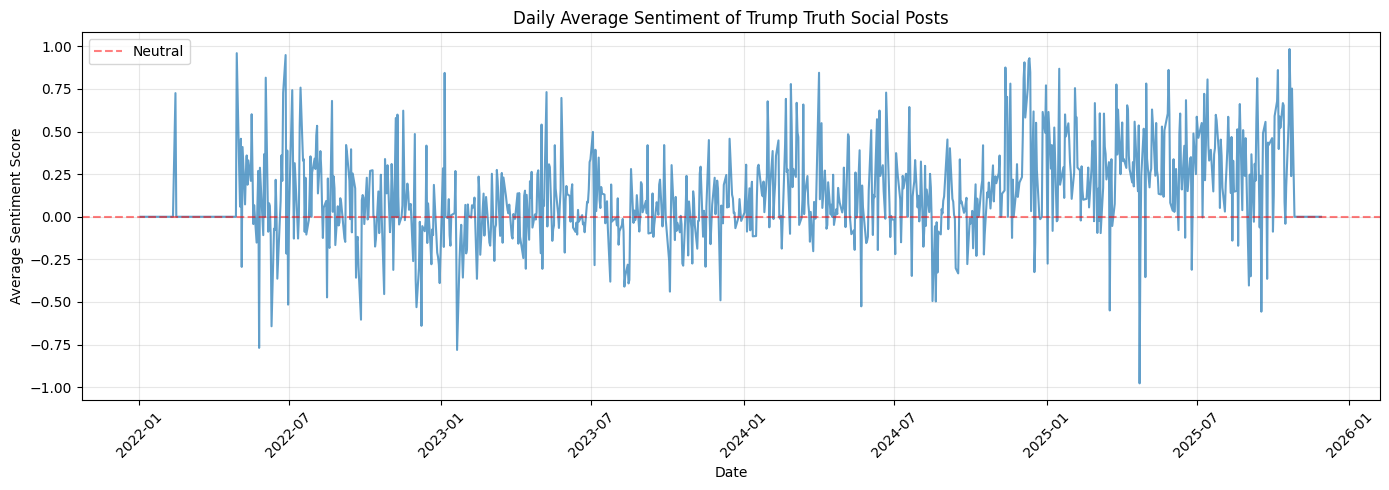

In [8]:
# Plot sentiment over time
plt.figure(figsize=(14, 5))
plt.plot(combined_df['date'], combined_df['avg_sentiment'], alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Neutral')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Daily Average Sentiment of Trump Truth Social Posts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Save data with sentiment scores
df_truth.to_csv('data/truth_social_with_sentiment.csv', index=False)
combined_df.to_csv('data/combined_data_with_sentiment.csv', index=False)